# HMC on Synthetic Regression

In [1]:
import os
import sys
from jax.config import config
import haiku as hk
import jax
from jax import numpy as jnp
import numpy as onp
import time
from jax.experimental.callback import rewrite
import tqdm

from bnn_hmc.utils import data_utils
from bnn_hmc.utils import models
from bnn_hmc.utils import losses
from bnn_hmc.utils import checkpoint_utils
from bnn_hmc.utils import cmd_args_utils
from bnn_hmc.utils import logging_utils
from bnn_hmc.utils import train_utils
from bnn_hmc.utils import tree_utils
from bnn_hmc.utils import precision_utils

import optax
import functools

from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# tpu_ip = "10.0.0.2"
# config.FLAGS.jax_xla_backend = "tpu_driver"
# config.FLAGS.jax_backend_target = "grpc://{}:8470".format(tpu_ip)
train_utils.set_up_jax(None, False)

## Data

In [16]:
data_npz = onp.load("synth_reg_data.npz")
x_ = jnp.asarray(data_npz["x_"])
y_ = jnp.asarray(data_npz["y_"])
f_ = jnp.asarray(data_npz["f_"])
x = jnp.asarray(data_npz["x"])
y = jnp.asarray(data_npz["y"])
f = jnp.asarray(data_npz["f"])

data_info = {"y_scale": 1.}

In [32]:
def inv_softplus(x):
    return jnp.log(jnp.exp(x) - 1)

# Noise in the data
noise_std = 0.02
invsp_noise_std = inv_softplus(noise_std)

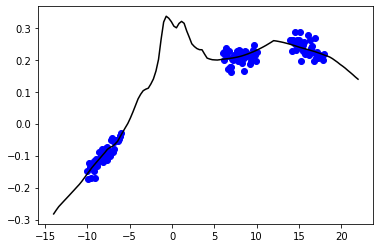

In [27]:
plt.plot(x, y, "bo")
plt.plot(x_, y_, "-k")

In [43]:
num_devices = len(jax.devices())
train_set = (f, y)
test_set = (f_, y_)
train_set = data_utils.pmap_dataset(train_set, num_devices)
test_set = data_utils.pmap_dataset(test_set, num_devices)

## Model

In [24]:
def make_model(layer_dims, invsp_noise_std):
    def forward(batch, is_training):
        x, _ = batch
        x = hk.Flatten()(x)
        for layer_dim in layer_dims:
            x = hk.Linear(layer_dim)(x)
            x = jax.nn.relu(x)
        x = hk.Linear(1)(x)
        x = jnp.concatenate([x, jnp.ones_like(x) * invsp_noise_std], -1)
        return x
    return forward

In [56]:
# net_fn = models.make_mlp_regression(data_info, output_dim=1, layer_dims=[100, 100, 100])
net_fn = make_model(layer_dims=[100, 100, 100], invsp_noise_std=invsp_noise_std)
net = hk.transform_with_state(net_fn)
net_apply, net_init = net.apply, net.init
net_apply = precision_utils.rewrite_high_precision(net_apply)

In [57]:
key, net_init_key = jax.random.split(jax.random.PRNGKey(0), 2)
start_iteration = 0
num_ensembled = 0
ensemble_predictions = None
step_size = 1.e-4

In [61]:
param_seed = 0
params, net_state = net.init(jax.random.PRNGKey(param_seed), (f, None), True)

std = 0.005
normal_key = jax.random.PRNGKey(10)

num_leaves = len(jax.tree_leaves(params))
normal_keys = list(jax.random.split(normal_key, num_leaves))
treedef = jax.tree_structure(params)
normal_keys = jax.tree_unflatten(treedef, normal_keys)
params = jax.tree_multimap(lambda p, key: jax.random.normal(key, p.shape) * std,
                           params, normal_keys)
net_state = jax.pmap(lambda _: net_state)(jnp.arange(num_devices))

## Prior and likelihood

In [62]:
prior_std = 0.1
weight_decay = 1 / prior_std**2

task = data_utils.Task("regression")
(likelihood_factory, predict_fn, ensemble_upd_fn, _,_) = train_utils.get_task_specific_fns(task, data_info)
log_prior_fn, log_prior_diff_fn = losses.make_gaussian_log_prior(weight_decay, 1.)

In [63]:
log_prior_fn, log_prior_diff_fn = (
    losses.make_gaussian_log_prior(weight_decay, 1.))
log_likelihood_fn = losses.make_gaussian_likelihood(1.)

## HMC update

In [64]:
step_size = 1e-5
trajectory_len = jnp.pi / 2 / jnp.sqrt(weight_decay)
max_num_leapfrog_steps = int(trajectory_len // step_size + 1)
print("Leapfrog steps per iteration:", max_num_leapfrog_steps)

Leapfrog steps per iteration: 15708


In [65]:
update, get_log_prob_and_grad = train_utils.make_hmc_update(
    net_apply, log_likelihood_fn, log_prior_fn, log_prior_diff_fn,
    max_num_leapfrog_steps, 1., 0.)

In [66]:
# Initial log-prob and grad values
log_prob, state_grad, log_likelihood, net_state = (
    get_log_prob_and_grad(train_set, params, net_state))

## Run HMC

In [ ]:
num_iterations = 100
all_test_preds = []

for iteration in tqdm.tqdm(range(num_iterations)):
    
#     in_burnin = (iteration < args.num_burn_in_iterations)
#     do_mh_correction = (not args.no_mh) and (not in_burnin)

    (params, net_state, log_likelihood, state_grad, step_size, key,
     accept_prob, accepted) = (
        update(train_set, params, net_state, log_likelihood, state_grad,
               key, step_size, trajectory_len, True))
    # Evaluation
    test_predictions = onp.asarray(
      predict_fn(net_apply, params, net_state, test_set))
    if accepted:
        all_test_preds.append(test_predictions)

    print("It: {} \t Accept P: {} \t Accepted {} \t Log-likelihood: {}".format(
            iteration, accept_prob, accepted, log_likelihood))

  1%|          | 1/100 [00:04<07:08,  4.32s/it]

It: 0 	 Accept P: 0.20859037339687347 	 Accepted True 	 Log-likelihood: 264.72412109375


  2%|▏         | 2/100 [00:08<07:06,  4.35s/it]

It: 1 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 283.1626281738281


  3%|▎         | 3/100 [00:12<06:59,  4.33s/it]

It: 2 	 Accept P: 0.5655859708786011 	 Accepted True 	 Log-likelihood: 303.48687744140625


  4%|▍         | 4/100 [00:17<06:51,  4.28s/it]

It: 3 	 Accept P: 0.8177406191825867 	 Accepted True 	 Log-likelihood: 305.7173156738281


  5%|▌         | 5/100 [00:21<06:46,  4.28s/it]

It: 4 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 307.953125


  6%|▌         | 6/100 [00:25<06:39,  4.25s/it]

It: 5 	 Accept P: 0.7260606288909912 	 Accepted False 	 Log-likelihood: 307.953125


  7%|▋         | 7/100 [00:29<06:35,  4.25s/it]

It: 6 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 306.0469665527344


  8%|▊         | 8/100 [00:34<06:29,  4.24s/it]

It: 7 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 307.5419006347656


  9%|▉         | 9/100 [00:38<06:24,  4.22s/it]

It: 8 	 Accept P: 0.5999127626419067 	 Accepted True 	 Log-likelihood: 305.2727966308594


 10%|█         | 10/100 [00:42<06:18,  4.20s/it]

It: 9 	 Accept P: 0.9791473746299744 	 Accepted True 	 Log-likelihood: 306.078857421875


 11%|█         | 11/100 [00:46<06:14,  4.21s/it]

It: 10 	 Accept P: 0.5954712629318237 	 Accepted False 	 Log-likelihood: 306.078857421875


 12%|█▏        | 12/100 [00:50<06:11,  4.22s/it]

It: 11 	 Accept P: 0.806975245475769 	 Accepted True 	 Log-likelihood: 302.55487060546875


 13%|█▎        | 13/100 [00:55<06:07,  4.23s/it]

It: 12 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 302.2354736328125


 14%|█▍        | 14/100 [00:59<06:05,  4.25s/it]

It: 13 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 305.40045166015625


 15%|█▌        | 15/100 [01:03<06:04,  4.29s/it]

It: 14 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 305.08929443359375


 16%|█▌        | 16/100 [01:08<06:06,  4.36s/it]

It: 15 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 304.83795166015625


 17%|█▋        | 17/100 [01:12<06:01,  4.35s/it]

It: 16 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 305.1680908203125


 18%|█▊        | 18/100 [01:17<05:55,  4.34s/it]

It: 17 	 Accept P: 0.7910500168800354 	 Accepted True 	 Log-likelihood: 303.4972229003906


 19%|█▉        | 19/100 [01:21<05:49,  4.32s/it]

It: 18 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 305.64990234375


 20%|██        | 20/100 [01:25<05:43,  4.30s/it]

It: 19 	 Accept P: 0.9564953446388245 	 Accepted True 	 Log-likelihood: 298.2762451171875


 21%|██        | 21/100 [01:29<05:37,  4.28s/it]

It: 20 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 303.2359619140625


 22%|██▏       | 22/100 [01:34<05:33,  4.28s/it]

It: 21 	 Accept P: 0.9471855163574219 	 Accepted True 	 Log-likelihood: 305.5938415527344


 23%|██▎       | 23/100 [01:38<05:30,  4.29s/it]

It: 22 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 302.67816162109375


 24%|██▍       | 24/100 [01:42<05:26,  4.30s/it]

It: 23 	 Accept P: 0.44964995980262756 	 Accepted False 	 Log-likelihood: 302.67816162109375


 25%|██▌       | 25/100 [01:47<05:24,  4.33s/it]

It: 24 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 303.92822265625


 26%|██▌       | 26/100 [01:51<05:19,  4.32s/it]

It: 25 	 Accept P: 0.4773370623588562 	 Accepted False 	 Log-likelihood: 303.92822265625


 27%|██▋       | 27/100 [01:55<05:15,  4.32s/it]

It: 26 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 306.2186279296875


 28%|██▊       | 28/100 [02:00<05:10,  4.32s/it]

It: 27 	 Accept P: 0.6704059839248657 	 Accepted False 	 Log-likelihood: 306.2186279296875


 29%|██▉       | 29/100 [02:04<05:07,  4.33s/it]

It: 28 	 Accept P: 0.5675419569015503 	 Accepted False 	 Log-likelihood: 306.2186279296875


 30%|███       | 30/100 [02:08<05:03,  4.34s/it]

It: 29 	 Accept P: 0.4967800974845886 	 Accepted True 	 Log-likelihood: 306.07342529296875


 31%|███       | 31/100 [02:13<05:00,  4.36s/it]

It: 30 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 307.17950439453125


 32%|███▏      | 32/100 [02:17<05:02,  4.44s/it]

It: 31 	 Accept P: 0.7923033237457275 	 Accepted True 	 Log-likelihood: 298.8511962890625


 33%|███▎      | 33/100 [02:22<04:57,  4.44s/it]

It: 32 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 306.61968994140625


 34%|███▍      | 34/100 [02:26<04:50,  4.40s/it]

It: 33 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 304.01763916015625


 35%|███▌      | 35/100 [02:31<04:47,  4.43s/it]

It: 34 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 304.37493896484375


 36%|███▌      | 36/100 [02:35<04:41,  4.40s/it]

It: 35 	 Accept P: 0.8216493129730225 	 Accepted True 	 Log-likelihood: 305.7777099609375


 37%|███▋      | 37/100 [02:39<04:35,  4.37s/it]

It: 36 	 Accept P: 0.3499954342842102 	 Accepted True 	 Log-likelihood: 305.7923583984375


 38%|███▊      | 38/100 [02:44<04:30,  4.36s/it]

It: 37 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 300.7176513671875


 39%|███▉      | 39/100 [02:48<04:25,  4.35s/it]

It: 38 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 302.1365966796875


 40%|████      | 40/100 [02:52<04:21,  4.37s/it]

It: 39 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 306.87261962890625


 41%|████      | 41/100 [02:57<04:19,  4.39s/it]

It: 40 	 Accept P: 0.6708927154541016 	 Accepted True 	 Log-likelihood: 303.4183349609375


 42%|████▏     | 42/100 [03:01<04:17,  4.45s/it]

It: 41 	 Accept P: 0.5442217588424683 	 Accepted True 	 Log-likelihood: 304.372802734375


 43%|████▎     | 43/100 [03:06<04:12,  4.43s/it]

It: 42 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 304.73883056640625


 44%|████▍     | 44/100 [03:10<04:07,  4.42s/it]

It: 43 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 304.59747314453125


 45%|████▌     | 45/100 [03:15<04:04,  4.44s/it]

It: 44 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 304.238037109375


 46%|████▌     | 46/100 [03:19<04:00,  4.45s/it]

It: 45 	 Accept P: 0.6901766657829285 	 Accepted True 	 Log-likelihood: 307.09979248046875


 47%|████▋     | 47/100 [03:23<03:54,  4.43s/it]

It: 46 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 307.8445739746094


 48%|████▊     | 48/100 [03:28<03:49,  4.41s/it]

It: 47 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 304.93463134765625


 49%|████▉     | 49/100 [03:32<03:45,  4.42s/it]

It: 48 	 Accept P: 0.6356095671653748 	 Accepted True 	 Log-likelihood: 304.191162109375


 50%|█████     | 50/100 [03:37<03:43,  4.48s/it]

It: 49 	 Accept P: 0.4877181649208069 	 Accepted True 	 Log-likelihood: 304.51959228515625


 51%|█████     | 51/100 [03:41<03:38,  4.46s/it]

It: 50 	 Accept P: 0.8239342570304871 	 Accepted True 	 Log-likelihood: 302.54901123046875


 52%|█████▏    | 52/100 [03:46<03:31,  4.42s/it]

It: 51 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 308.30255126953125


 53%|█████▎    | 53/100 [03:50<03:26,  4.40s/it]

It: 52 	 Accept P: 0.8127089738845825 	 Accepted True 	 Log-likelihood: 305.3276062011719


 54%|█████▍    | 54/100 [03:54<03:21,  4.38s/it]

It: 53 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 301.68243408203125


 55%|█████▌    | 55/100 [03:59<03:16,  4.36s/it]

It: 54 	 Accept P: 0.8917319774627686 	 Accepted True 	 Log-likelihood: 305.1502685546875


 56%|█████▌    | 56/100 [04:03<03:11,  4.35s/it]

It: 55 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 306.04730224609375


 57%|█████▋    | 57/100 [04:07<03:06,  4.34s/it]

It: 56 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 304.60888671875


 58%|█████▊    | 58/100 [04:12<03:03,  4.37s/it]

It: 57 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 306.2462158203125


 59%|█████▉    | 59/100 [04:16<02:59,  4.38s/it]

It: 58 	 Accept P: 0.7897264361381531 	 Accepted True 	 Log-likelihood: 304.31500244140625


 60%|██████    | 60/100 [04:21<02:56,  4.40s/it]

It: 59 	 Accept P: 0.7606061100959778 	 Accepted True 	 Log-likelihood: 304.5753173828125


 61%|██████    | 61/100 [04:25<02:51,  4.40s/it]

It: 60 	 Accept P: 0.812684178352356 	 Accepted False 	 Log-likelihood: 304.5753173828125


 62%|██████▏   | 62/100 [04:29<02:49,  4.45s/it]

It: 61 	 Accept P: 0.9605173468589783 	 Accepted False 	 Log-likelihood: 304.5753173828125


 63%|██████▎   | 63/100 [04:34<02:43,  4.43s/it]

It: 62 	 Accept P: 0.8020771145820618 	 Accepted True 	 Log-likelihood: 302.2872314453125


 64%|██████▍   | 64/100 [04:38<02:38,  4.41s/it]

It: 63 	 Accept P: 0.7953254580497742 	 Accepted True 	 Log-likelihood: 298.8271484375


 65%|██████▌   | 65/100 [04:43<02:34,  4.43s/it]

It: 64 	 Accept P: 0.7411268949508667 	 Accepted False 	 Log-likelihood: 298.8271484375


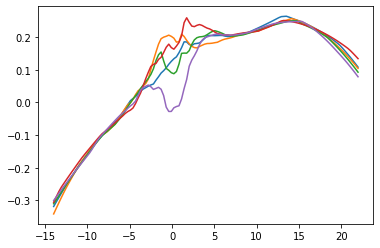

In [54]:
for pred in all_test_preds[-5:]:
    plt.plot(x_, pred[0, :, 0])

# Old

In [94]:
update, get_log_prob_and_grad, evaluate = train_utils.make_hmc_update(
    net_apply, log_likelihood_fn, log_prior_fn, log_prior_diff_fn,
    0., 0.)

In [93]:
num_devices = len(jax.devices())
train_set = (f, y)
test_set = (f_, y_)
train_set = data.pmap_dataset(train_set, num_devices)
test_set = data.pmap_dataset(test_set, num_devices)

net_state = jax.pmap(lambda _: net_state)(jnp.arange(num_devices))

In [95]:
log_prob, state_grad, log_likelihood, net_state = (
    get_log_prob_and_grad(train_set, params, net_state))
print(log_prob)

-39540.977


In [97]:
key = jax.random.PRNGKey(10)
all_pred_y_ = []
save_freq = 10

for iteration in tqdm.tqdm(range(201)):
    (params, net_state, log_likelihood, state_grad, step_size, key, accept_prob, accepted) = (
        update(train_set, params, net_state, log_likelihood, state_grad,
               key, step_size, trajectory_len, False))
    pred_y_, _ = net_apply(params, net_state, None, (f_, None), False)
    all_pred_y_.append(onp.asarray(pred_y_))
    
#     if iteration % save_freq == 0:
#         checkpoint_name = checkpoint_utils.make_checkpoint_name(iteration)
#         checkpoint_dict = checkpoint_utils.make_hmc_checkpoint_dict(
#             iteration, params, net_state, key, step_size, accepted, None,
#             None)
#         checkpoint_utils.save_checkpoint(checkpoint_name, checkpoint_dict)

100%|██████████| 201/201 [05:05<00:00,  1.52s/it]


In [98]:
all_pred_y_stack_ = onp.concatenate([preds[None, :, 0] for preds in all_pred_y_])

In [99]:
all_pred_y_stack_ = all_pred_y_stack_[10:]

In [100]:
pred_mean = onp.mean(all_pred_y_stack_, axis=0)
pred_std = onp.std(all_pred_y_stack_, axis=0)

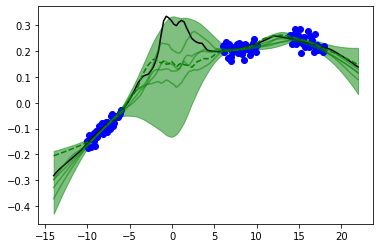

In [101]:
pred_y_, _ = net_apply(params, net_state, None, (f_, None), False)
plt.plot(x, y, "bo")
plt.plot(x_, y_, "-k")
plt.fill_between(x_, pred_mean + 3*pred_std, pred_mean - 3*pred_std, color="g", alpha=0.5)
plt.plot(x_, all_pred_y_[-1], "--g")
for preds in all_pred_y_stack_[::50]:
    plt.plot(x_, preds, alpha=0.5, color="g")

In [102]:
# onp.savez("predictive_1.npz", preds=all_pred_y_stack_)

## Compare two chains

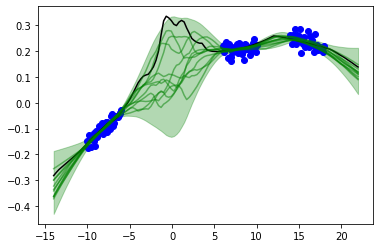

In [103]:
all_pred_y_stack_ = onp.load("predictive_1.npz")["preds"]
pred_mean = onp.mean(all_pred_y_stack_, axis=0)
pred_std = onp.std(all_pred_y_stack_, axis=0)

plt.plot(x, y, "bo")
plt.plot(x_, y_, "-k")
plt.fill_between(x_, pred_mean + 3*pred_std, pred_mean - 3*pred_std, color="g", alpha=0.3)
for preds in all_pred_y_stack_[::20]:
    plt.plot(x_, preds, alpha=0.5, color="g")

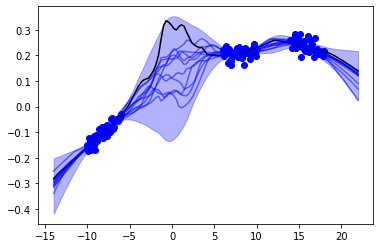

In [104]:
all_pred_y_stack_ = onp.load("predictive_0.npz")["preds"]
pred_mean = onp.mean(all_pred_y_stack_, axis=0)
pred_std = onp.std(all_pred_y_stack_, axis=0)

plt.plot(x, y, "bo")
plt.plot(x_, y_, "-k")
plt.fill_between(x_, pred_mean + 3*pred_std, pred_mean - 3*pred_std, color="b", alpha=0.3)
for preds in all_pred_y_stack_[::20]:
    plt.plot(x_, preds, alpha=0.5, color="b")

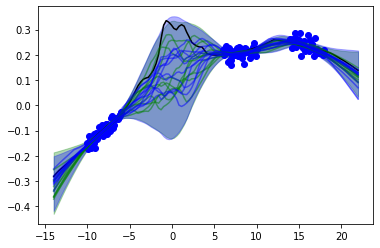

In [105]:
all_pred_y_stack_ = onp.load("predictive_1.npz")["preds"]
pred_mean = onp.mean(all_pred_y_stack_, axis=0)
pred_std = onp.std(all_pred_y_stack_, axis=0)

plt.plot(x, y, "bo")
plt.plot(x_, y_, "-k")
plt.fill_between(x_, pred_mean + 3*pred_std, pred_mean - 3*pred_std, color="g", alpha=0.3)
for preds in all_pred_y_stack_[::20]:
    plt.plot(x_, preds, alpha=0.5, color="g")
    
    all_pred_y_stack_ = onp.load("predictive_0.npz")["preds"]
pred_mean = onp.mean(all_pred_y_stack_, axis=0)
pred_std = onp.std(all_pred_y_stack_, axis=0)

plt.fill_between(x_, pred_mean + 3*pred_std, pred_mean - 3*pred_std, color="b", alpha=0.3)
for preds in all_pred_y_stack_[::20]:
    plt.plot(x_, preds, alpha=0.5, color="b")

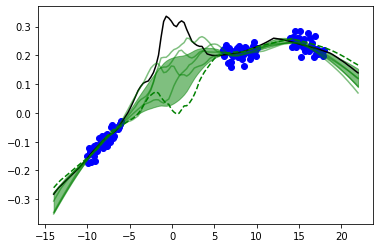

In [68]:
pred_y_, _ = net_apply(params, net_state, None, (f_, None), False)
plt.plot(x, y, "bo")
plt.plot(x_, y_, "-k")
plt.fill_between(x_, pred_mean + pred_std, pred_mean - pred_std, color="g", alpha=0.5)
plt.plot(x_, all_pred_y_[-1], "--g")
for preds in all_pred_y_stack_[::50]:
    plt.plot(x_, preds, alpha=0.5, color="g")

In [70]:
# onp.savez("predictive_1.npz", preds=all_pred_y_stack_)
# onp.savez("predictive_0.npz", preds=all_pred_y_stack_)

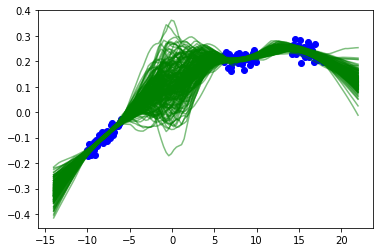

In [69]:
pred_y_, _ = net_apply(params, net_state, None, (f_, None), False)
plt.plot(x, y, "bo")
# plt.fill_between(x_, pred_mean + pred_std, pred_mean - pred_std, color="g", alpha=0.5)
for preds in all_pred_y_stack_[::1]:
    plt.plot(x_, preds, alpha=0.5, color="g")

## Loss Surface

In [111]:
def tree_diff(a, b):
    return jax.tree_multimap(lambda p_a, p_b: p_a - p_b, a, b)
def tree_norm(a):
    return float(jnp.sqrt(sum([jnp.sum(p_a**2) for p_a in jax.tree_leaves(a)])))
    
def get_u_v_o(params1, params2, params3):
    
#     print([p.shape for p in jax.tree_leaves(params1)])
    
    u_params = tree_diff(params2, params1)
    u_norm = tree_norm(u_params)
    u_params = tree_utils.tree_scalarmul(u_params, 1 / u_norm)
    v_params = tree_diff(params3, params1)
    uv_dot = tree_utils.tree_dot(u_params, v_params)
    v_params = jax.tree_multimap(lambda v, u: v - uv_dot * u, v_params, u_params)
    v_norm = tree_norm(v_params)
    v_params = tree_utils.tree_scalarmul(v_params, 1 / v_norm)
    
    return u_params, u_norm, v_params, v_norm, params1

In [107]:
checkpoint_dict = checkpoint_utils.load_checkpoint("model_step_100.pt")
params1 = checkpoint_dict["params"]

checkpoint_dict = checkpoint_utils.load_checkpoint("model_step_150.pt")
params2 = checkpoint_dict["params"]

checkpoint_dict = checkpoint_utils.load_checkpoint("model_step_200.pt")
params3 = checkpoint_dict["params"]

In [108]:
for params in [params1, params2, params3]:
    log_prob, _, _, _ = evaluate(params, net_state, train_set)
    print(log_prob)

-38898.477
-38923.75
-38970.83


In [471]:
u_params, u_norm, v_params, v_norm, o_params = get_u_v_o(params1, params2, params3)

u_ts = onp.linspace(-.25, 1.25, 40)
v_ts = onp.linspace(-.25, 1.25, 40)
n_u, n_v = len(u_ts), len(v_ts)
log_probs = onp.zeros((n_u, n_v))
grid = onp.zeros((n_u, n_v, 2))

for u_i, u_t in enumerate(tqdm.tqdm(u_ts)):
    for v_i, v_t in enumerate(v_ts):
        grid[u_i, v_i] = [u_t, v_t]
        params = jax.tree_multimap(lambda u, v, o: o + u * u_t * u_norm + v * v_t * v_norm, 
                                   u_params, v_params, o_params)
        log_prob, _, _, _ = evaluate(params, net_state, train_set)
        log_probs[u_i, v_i] = float(log_prob)

100%|██████████| 40/40 [01:42<00:00,  2.56s/it]


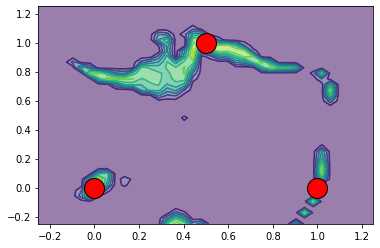

In [472]:
log_probs_cliped = onp.clip(log_probs, -7.e4, 0)
plt.contour(grid[:, :, 0], grid[:, :, 1], log_probs_cliped, zorder=1)
plt.contourf(grid[:, :, 0], grid[:, :, 1], log_probs_cliped, zorder=0, alpha=0.55)
plt.plot([0., 1., 0.5], [0., 0., 1.], "ro", ms=20, markeredgecolor="k")

## Distance analysis

In [119]:
checkpoint_dict = checkpoint_utils.load_checkpoint("model_step_100.pt")
params1 = checkpoint_dict["params"]

checkpoint_dict = checkpoint_utils.load_checkpoint("model_step_200.pt")
params2 = checkpoint_dict["params"]

In [120]:
d = sum([jnp.size(p) for p in jax.tree_leaves(params1)])
theory_dist = jnp.sqrt(2 * d * prior_std**2)

dist = tree_norm(tree_diff(params2, params1))
print(dist, theory_dist)

20.265684127807617 20.298277


In [5]:
a,b,c = zip(*[[1, "a", 0.1], [2, "b", 0.2], [3, "c", 0.3]])